## Modèles Atemporel avec XgBoost :
### Demande(quantité) par produit 
####  ici un cas particulier $product_{id} = "5cebfa8d0b259700045dc8ad" $

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os 
os.environ["ENV"]="LOCAL"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="../store_order_service_account"
#print(os.environ) 
os.chdir("/Users/gnabeyeuemmanuel/Desktop/demandEstimate/demand-service")

### 1. Import usefull libraries

In [3]:
import os
import sys
import sys; 
sys.path.insert(0, '..')
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA, NMF,FastICA,TruncatedSVD,IncrementalPCA
from sklearn.cluster import KMeans
#import pandasgui

%matplotlib inline
import google.cloud.secretmanager as secretmanager

from utils.utility_fct import get_table_sql,cross_product

2022-06-17 09:56:11,924 — utils.utility_fct — INFO — logging with perso-pierre-ro


In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_squared_log_error
from xgboost import plot_importance, plot_tree

from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

import time
sns.set_style('whitegrid')
plt.rcParams['figure.figsize']=(20,10) # for graphs styling
plt.style.use('tableau-colorblind10') # for graph stying

#from french_holidays import get_french_holiday_calendar

### 2. Load and Plot the time series dataset

In [5]:
# load dataset
series = pd.read_csv('/Users/gnabeyeuemmanuel/Desktop/demande.csv', header=0) #index_col=0
#print(values)
#visualize
print(series.columns)
print(series.describe())

series.head()

Index(['product_id', 'store_id', 'date', 'product_count'], dtype='object')
       product_count
count  223518.000000
mean        1.498627
std         1.014533
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        56.000000


,product_id,store_id,date,product_count
0,5cebfa8d0b259700045dc8aa,5f1198de8746ae00042869ba,2022-02-03,1
1,5cebfa8d0b259700045dc8aa,5f1198de8746ae00042869ba,2022-02-05,1
2,5cebfa8d0b259700045dc8aa,5f1198de8746ae00042869ba,2022-02-09,2
3,5cebfa8d0b259700045dc8aa,5f1198de8746ae00042869ba,2022-02-10,1
4,5cebfa8d0b259700045dc8aa,5f1198de8746ae00042869ba,2022-02-13,2


In [6]:
series.corr()

,product_count
product_count,1.0


<AxesSubplot:xlabel='date'>

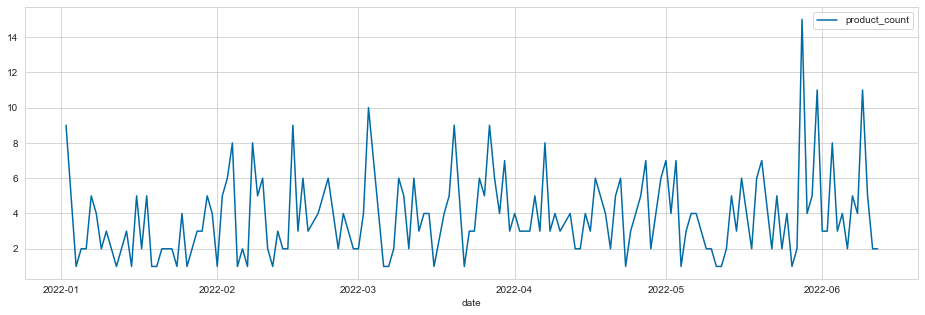

In [7]:
df_q = series.query("product_id == '5cebfa8d0b259700045dc8ad'") 
series1=df_q.iloc[:,2:4]
series1['date'] = pd.to_datetime(series1['date']).dt.date
series1 = pd.DataFrame(series1.groupby(series1['date'])['product_count'].sum())
series1.plot(figsize=(16,5))

1. générer les points manquants (dates absentes) pd.date_range + fillna(0)
2. df_p = df indexée par les dates sur un produit
3. décaler df_p n fois (du coup on obtient une dataframe avec n colonnes, une par décalage)
4. calculer df_p.corr()

### 3. Create Time-Series Features
#### At first in order to check correlations

In [8]:
series2 = series1.groupby(['date'])['product_count'].sum().reset_index()

In [9]:

series2['date'] = pd.to_datetime(series2['date']).dt.date
series2.columns

Index(['date', 'product_count'], dtype='object')

In [10]:
# Setting features for the XGBoost
#series1['Year'] = pd.to_datetime(series1['date']).dt.year
series2['Month'] = pd.to_datetime(series2['date']).dt.month
series2['Week'] = pd.to_datetime(series2['date']).dt.week
series2['Day'] = pd.to_datetime(series2['date']).dt.day
series2['WeekDay'] = pd.to_datetime(series2['date']).dt.dayofweek
series2['Weekend'] = series2.WeekDay.isin([5, 6]).astype(int)
series2.head()

,date,product_count,Month,Week,Day,WeekDay,Weekend
0,2022-01-02,9,1,52,2,6,1
1,2022-01-03,5,1,1,3,0,0
2,2022-01-04,1,1,1,4,1,0
3,2022-01-05,2,1,1,5,2,0
4,2022-01-06,2,1,1,6,3,0


Let's to check the correlations: **Pearson correlation coefficient.**

In [11]:
cor=series2.corr()
cor

,product_count,Month,Week,Day,WeekDay,Weekend
product_count,1.000000,0.164180,0.260337,0.080759,0.073094,0.024760
Month,0.164180,1.000000,0.828701,-0.144762,0.044321,0.014383
Week,0.260337,0.828701,1.000000,-0.034544,0.071786,0.060607
Day,0.080759,-0.144762,-0.034544,1.000000,0.003464,0.034393
WeekDay,0.073094,0.044321,0.071786,0.003464,1.000000,0.798305
Weekend,0.024760,0.014383,0.060607,0.034393,0.798305,1.000000


<AxesSubplot:>

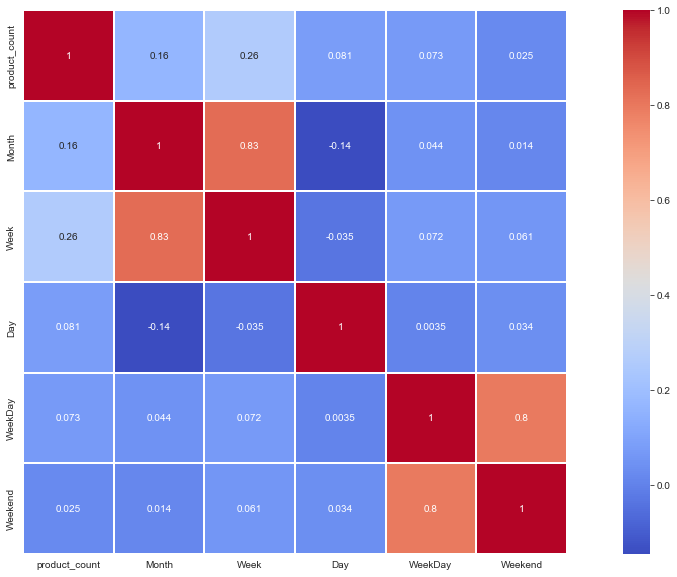

In [12]:
sns.heatmap(cor, square = True, cmap="coolwarm",linewidths=.3,annot=True )

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

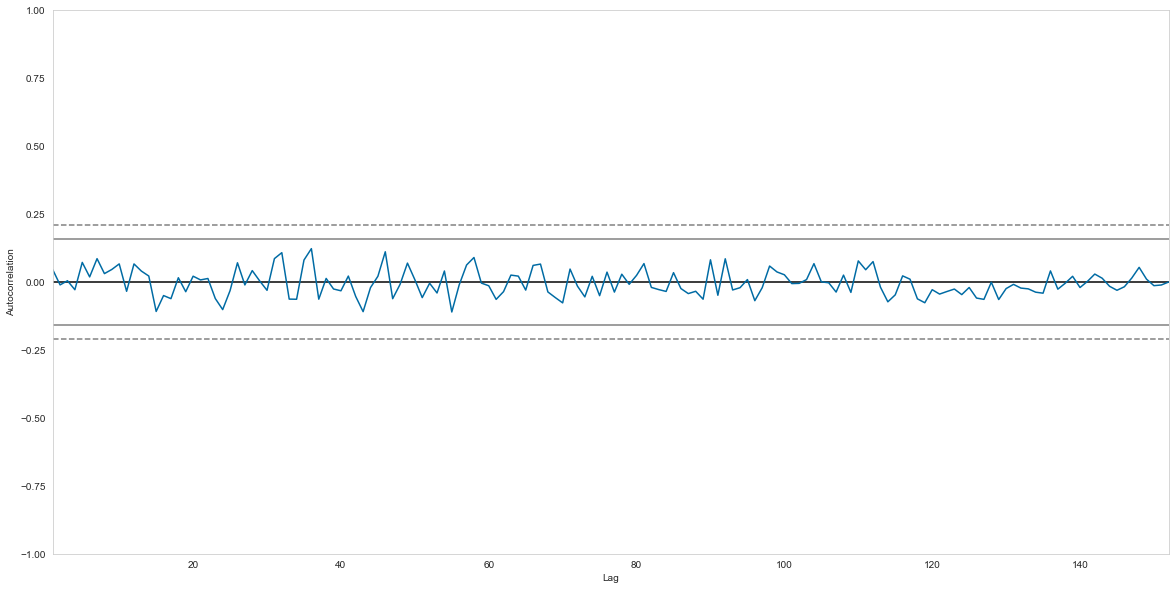

In [13]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series2['product_count'])

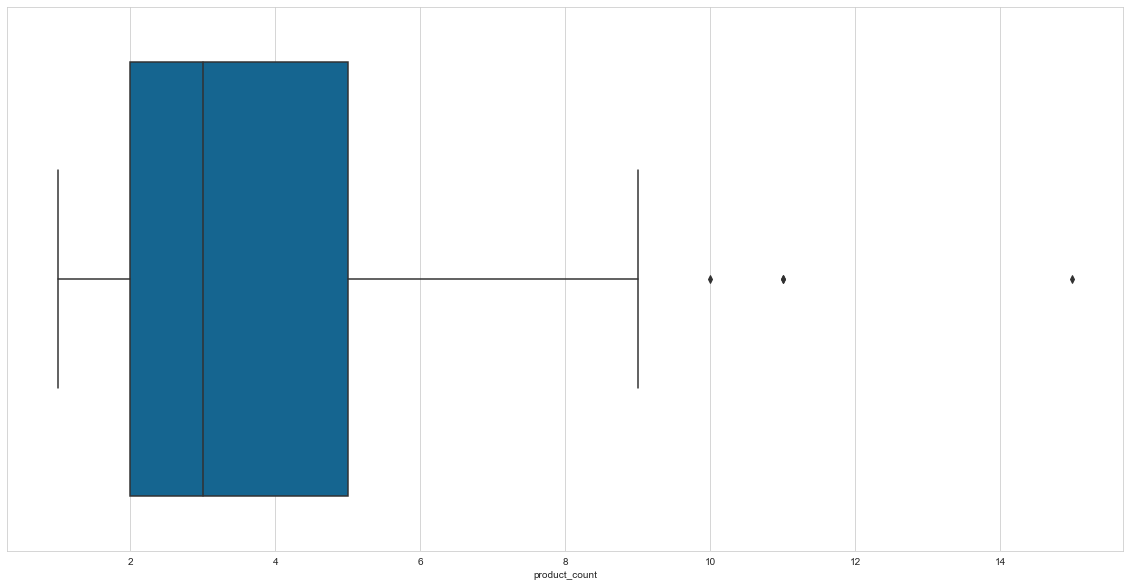

In [14]:
sns.boxplot(x=series2['product_count'])
plt.show()

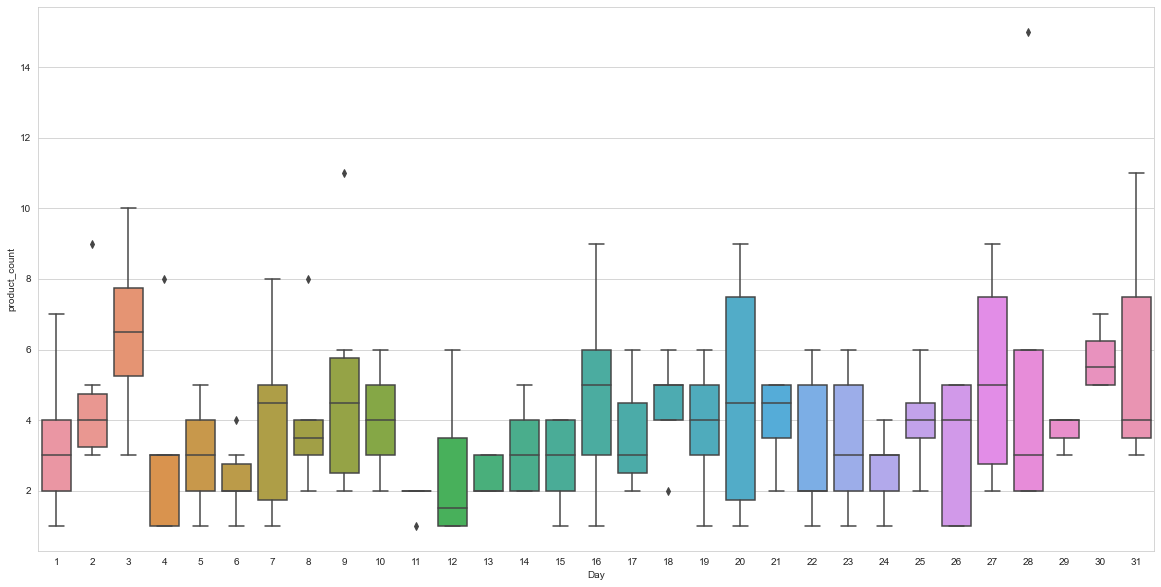

In [15]:
sns.boxplot(series2['Day'], series2['product_count'])
plt.show()

 **Is there a Monthly Seasonality ?  So that there should be definitely a feature in our model for capturing it ?**


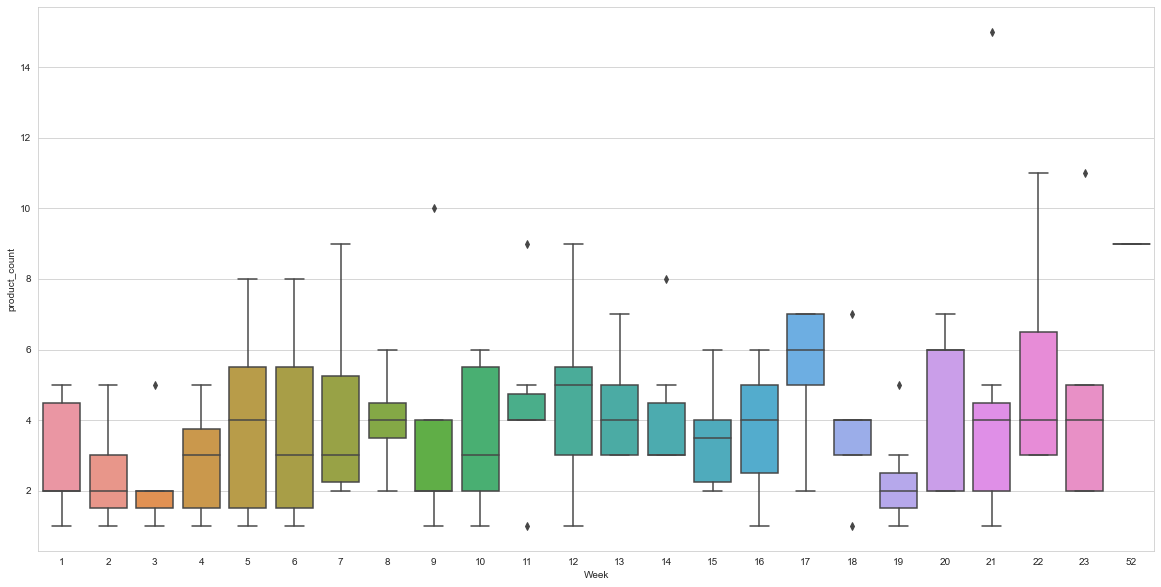

In [16]:
sns.boxplot(series2['Week'], series2['product_count'])
plt.show()

 **Quantitative analysis to kick out some outliers qualitatively ?
 We can see from the plot above that any value lower 0 is an outlier and any above 30 respectively**

In [ ]:
#series1 = series1[series1['product_count'] <=30]
#series1 = training_df[training_df['product_count'] >=0]
#series1.drop(['date'], axis=1, inplace=True)

### 4. Train/Test-Split

In [17]:
import datetime
split_date = datetime.date(2022,5,10) #pd.to_datetime(2022-5-10)
print(split_date)
train_set = series2.loc[series2['date']<= split_date].copy()
test_set = series2.loc[series2['date']> split_date].copy()

2022-05-10


In [18]:
train_set.set_index('date', inplace=True)
train_set = train_set[datetime.date(2022,1,2):]
train_set.head()


,product_count,Month,Week,Day,WeekDay,Weekend
date,,,,,,
2022-01-02,9,1,52,2,6,1
2022-01-03,5,1,1,3,0,0
2022-01-04,1,1,1,4,1,0
2022-01-05,2,1,1,5,2,0
2022-01-06,2,1,1,6,3,0


In [19]:
train_set.index[1]

datetime.date(2022, 1, 3)

In [20]:
test_set.set_index('date', inplace=True) 
test_set=test_set[datetime.date(2022,5,11):]
test_set.head()

,product_count,Month,Week,Day,WeekDay,Weekend
date,,,,,,
2022-05-11,1,5,19,11,2,0
2022-05-12,1,5,19,12,3,0
2022-05-13,2,5,19,13,4,0
2022-05-14,5,5,19,14,5,1
2022-05-15,3,5,19,15,6,1


In [21]:
test_set.index[1]

datetime.date(2022, 5, 12)

### 5. Create Time-Series Features for the Model

Jour de la semaine?
Jour du mois?
Mois de l’année?
Vacances?
Jour fériés?
Temperature?
meteo ?
Precipitations?


In [22]:
def create_features(df:pd.DataFrame, target=None):
    df['date'] = df.index
    df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d') #df['date']=pd.to_datetime(df['date'],errors='coerce').dt.date
    
    #df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    #df['month'] = df['date'].dt.month
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    #df['year'] = df['date'].dt.year
    X = df[['dayofweek','dayofyear',
            'dayofmonth', 'weekofyear'
           ]]
    if target:
        y = df[target]
        return X, y
    return X

In [23]:
X_train, y_train = create_features(train_set, target='product_count')
X_test, y_test = create_features(test_set, target='product_count')

In [24]:
X_train.head()

,dayofweek,dayofyear,dayofmonth,weekofyear
date,,,,
2022-01-02,6,2,2,52
2022-01-03,0,3,3,1
2022-01-04,1,4,4,1
2022-01-05,2,5,5,1
2022-01-06,3,6,6,1


### 6.  Creating the XGBoost Model

In [ ]:
# A parameter grid for XGBoost
#model = make_pipeline(MinMaxScaler(), GradientBoostingRegressor())
#params = {'gradientboostingregressor__max_depth': range(3, 20)}

params = {
    'min_child_weight': [4, 8],
    'gamma': [i / 10.0 for i in range(3, 6)],
    'subsample': [i / 10.0 for i in range(5, 11)], #range(6,11)?
    'colsample_bytree': [i / 10.0 for i in range(5, 11)],
    'max_depth': [3, 4, 5], ##
    'eta': [0.01,0.05, 0.1, 0.15,0.2,0.3,0.5]
}
# Initialize XGB and GridSearch
xgb_reg = xgb.XGBRegressor(nthread=-1, objective='reg:squarederror',n_estimators=1000)

model = make_pipeline(MinMaxScaler(), xgb_reg) 

#eval_set = [(X_test, y_test)]
#model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)

grid = GridSearchCV(xgb_reg, params,cv=5) # the default 5-fold cross validation or None
grid.fit(X_train, y_train)

gridcv_xgb = grid.best_estimator_

gridcv_xgb.score(X_test, y_test)

In [ ]:
print(r2_score(y_test, gridcv_xgb.predict(X_test)))

In [ ]:
grid.best_params_

Look at or visualize the Feature importances ?

In [ ]:
_ = plot_importance(gridcv_xgb, height=1.5)

In [ ]:
variances = grid.best_estimator_.feature_importances_  ##named_steps['eXtremeGradientBoostingregressor'].
serie = pd.Series(variances, index=X_train.columns, name='Explained Variances')
plt.figure(figsize=(18,6))
plt.bar(serie.index,serie)
plt.show()

### 7.Evaluate the Model: 
#### $ metrics: (MSE; MSLE; R^{2};  MAE; MAPE)?$
With the test_set

In [ ]:
test_set['Prediction'] = gridcv_xgb.predict(X_test)
df_all = pd.concat([test_set, train_set], sort=False)
_ = df_all[['product_count','Prediction']].plot(figsize=(15, 5))

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['Prediction','product_count']].plot(ax=ax, style=['-','o'])
ax.set_xbound(lower= datetime.date(2022,5,11), upper=datetime.date(2022,7,1)) #'2022–05–11' '2022–07–01'
plot = plt.suptitle('May 2022 onwards Forecast vs Actuals')

In [ ]:
MSE=mean_squared_error(y_true=test_set['product_count'],
                   y_pred=test_set['Prediction'])
MAE=mean_absolute_error(y_true=test_set['product_count'],
                   y_pred=test_set['Prediction'])
MSLE=mean_squared_log_error(y_true=test_set['product_count'],
                   y_pred=test_set['Prediction'])
print('MSE: %.3f' % MSE)
print('MAE: %.3f' % MAE)
print('MSLE: %.3f' %MSLE)

### 8.Create Forecast

In [ ]:
# create an array of 15 dates starting at '2022-06-15', one per 2day horizon h=7
rng = pd.date_range(datetime.date(2022,6,12), periods=7, freq='2D')
test = pd.DataFrame({ 'date': rng,'product_count':np.nan}) 
test

In [ ]:
test.set_index('date', inplace=True) 
pred_x,pred_y  = create_features(test, target='product_count')
pred_x
test['xgb_Prediction'] = gridcv_xgb.predict(pred_x)
test.drop(['product_count','dayofweek','dayofyear','dayofmonth', 
           'weekofyear','date'], axis=1, inplace=True)
test



In [ ]:
series2['product_count'].mean()

##### Plot the predictions:

NameError: name 'test' is not defined

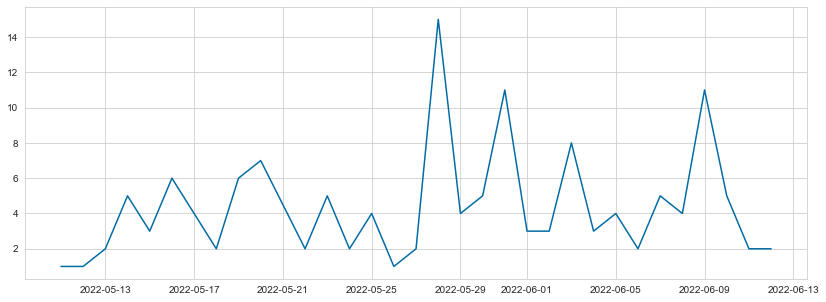

In [25]:
plt.figure(figsize=(14,5))
plt.plot(test_set['product_count'][datetime.date(2022,5,1):])
plt.plot(test['xgb_Prediction'])
plt.legend(['product_count', 'xgb_Prediction'])
plt.show()

1. générer les points manquants (dates absentes) pd.date_range + fillna(0)
2. df_p = df indexée par les dates sur un produit
3. décaler df_p n fois (du coup on obtient une dataframe avec n colonnes, une par décalage)
4. calculer df_p.corr()

In [26]:
df_q['date']=pd.to_datetime(df_q['date'])
df_q2 = df_q.groupby(['date','product_id']).sum().reset_index()
df_q2

,date,product_id,product_count
0,2022-01-02,5cebfa8d0b259700045dc8ad,9
1,2022-01-03,5cebfa8d0b259700045dc8ad,5
2,2022-01-04,5cebfa8d0b259700045dc8ad,1
3,2022-01-05,5cebfa8d0b259700045dc8ad,2
4,2022-01-06,5cebfa8d0b259700045dc8ad,2
...,...,...,...
147,2022-06-08,5cebfa8d0b259700045dc8ad,4
148,2022-06-09,5cebfa8d0b259700045dc8ad,11
149,2022-06-10,5cebfa8d0b259700045dc8ad,5
150,2022-06-11,5cebfa8d0b259700045dc8ad,2


In [107]:
df=pd.date_range(start=df_q2['date'].min(), end=df_q2['date'].max())
df=df.to_frame().rename({0:'date'},axis=1)
df= df.merge(df_q2,on='date', how='left').fillna({'product_count':0}).sort_values('date')

In [28]:
for i in range(15):
    df['product_count_'+str(i+1)]=df['product_count'].shift(i+1)
df.corr()

,product_count,product_count_1,product_count_2,product_count_3,product_count_4,product_count_5,product_count_6,product_count_7,product_count_8,product_count_9,product_count_10,product_count_11,product_count_12,product_count_13,product_count_14,product_count_15
product_count,1.000000,0.085491,-0.068573,-0.003395,-0.093537,0.097495,0.149117,-0.056906,0.048883,0.117958,-0.003923,-0.036515,0.090885,-0.017852,-0.027958,0.035747
product_count_1,0.085491,1.000000,0.083076,-0.066539,0.008876,-0.092975,0.100147,0.146832,-0.056286,0.047957,0.127034,-0.004908,-0.037574,0.107637,-0.015148,-0.027076
product_count_2,-0.068573,0.083076,1.000000,0.085474,-0.056224,0.009585,-0.090786,0.097701,0.147756,-0.057375,0.056236,0.126254,-0.005910,-0.025081,0.110703,-0.014250
product_count_3,-0.003395,-0.066539,0.085474,1.000000,0.077251,-0.056890,0.007543,-0.088707,0.097209,0.148779,-0.064534,0.057119,0.127220,-0.017217,-0.027337,0.110095
product_count_4,-0.093537,0.008876,-0.056224,0.077251,1.000000,0.076256,-0.069989,0.020463,-0.094683,0.104829,0.118897,-0.061920,0.063433,0.072645,-0.030249,-0.032323
product_count_5,0.097495,-0.092975,0.009585,-0.056890,0.076256,1.000000,0.075664,-0.069312,0.020270,-0.094436,0.103912,0.119194,-0.061669,0.061882,0.072039,-0.030485
product_count_6,0.149117,0.100147,-0.090786,0.007543,-0.069989,0.075664,1.000000,0.078329,-0.070053,0.021215,-0.102510,0.104924,0.120242,-0.075857,0.059616,0.071330
product_count_7,-0.056906,0.146832,0.097701,-0.088707,0.020463,-0.069312,0.078329,1.000000,0.079131,-0.071131,0.029008,-0.103631,0.104110,0.137471,-0.073414,0.060593
product_count_8,0.048883,-0.056286,0.147756,0.097209,-0.094683,0.020270,-0.070053,0.079131,1.000000,0.079438,-0.074110,0.029288,-0.103391,0.103850,0.136933,-0.073676
product_count_9,0.117958,0.047957,-0.057375,0.148779,0.104829,-0.094436,0.021215,-0.071131,0.079438,1.000000,0.082952,-0.074467,0.028952,-0.101878,0.104981,0.137297


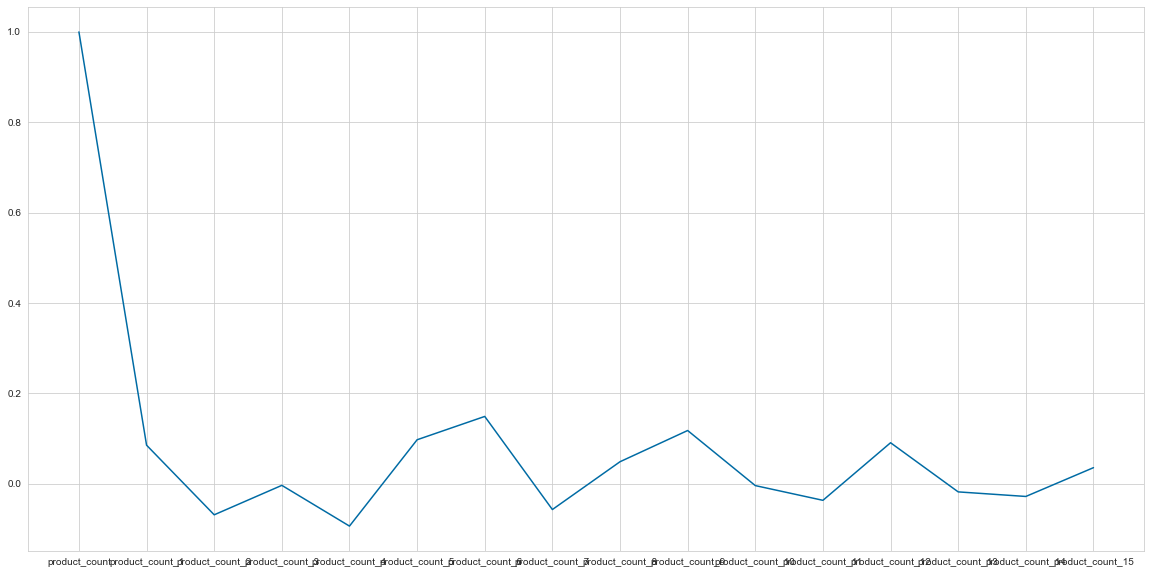

In [29]:
plt.plot(df.corr().iloc[0,:])

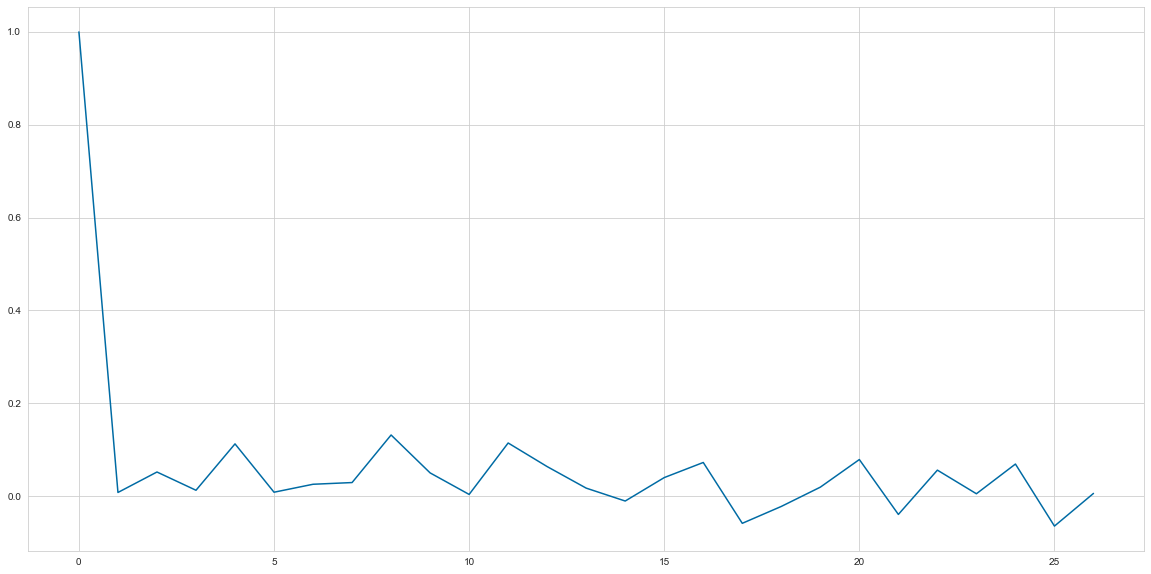

In [30]:
from statsmodels.tsa.stattools import acf
cor = acf(df_q['product_count'])
plt.plot(cor)

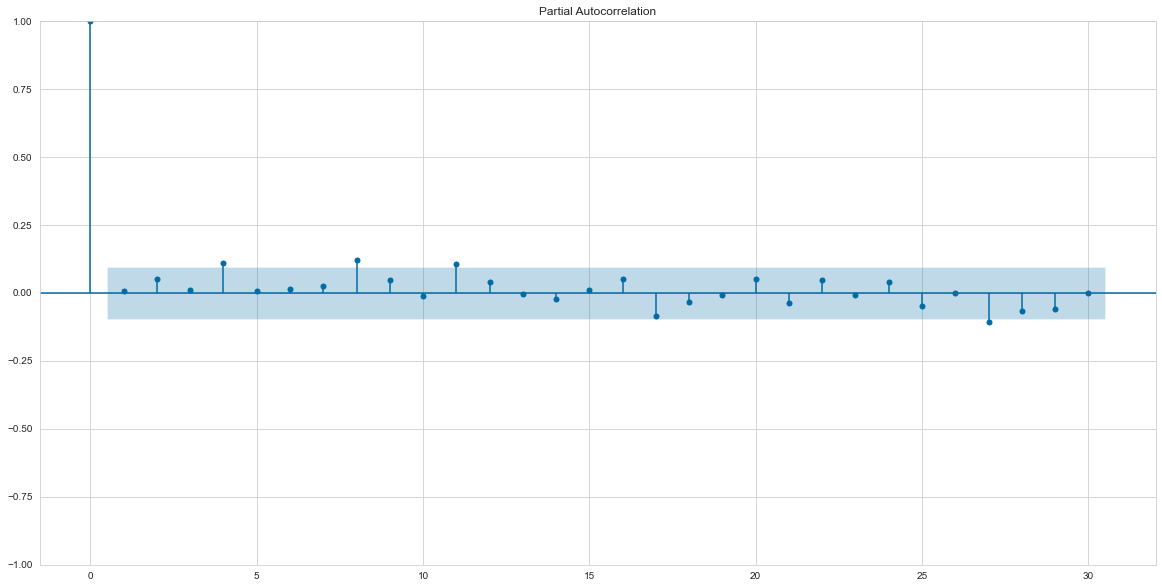

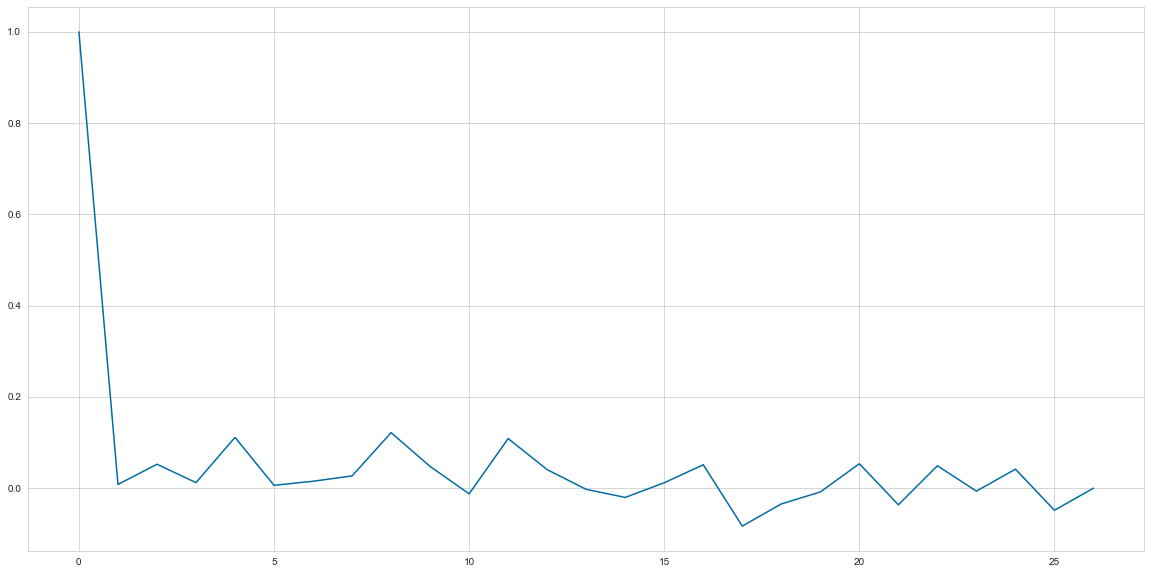

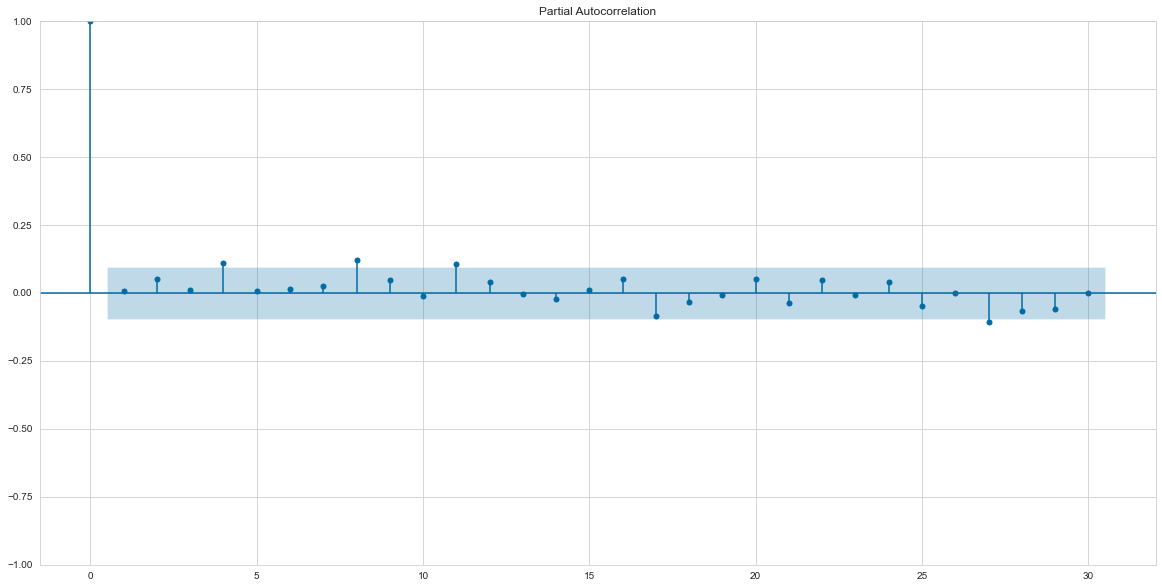

In [31]:
#partial autocorrélation
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
pcor = pacf(df_q['product_count'])
plt.plot(pcor)
plot_pacf(df_q['product_count'], lags=30)

##### Référence = Moyenne des ventes sur cette période ?

In [32]:
series2['product_count'].mean()

3.861842105263158

##### Regression Linéaire

In [33]:
##tendance:  on l’obtient en réalisant une régression linéaire de Y sur le temps t.
from statsmodels.api import OLS

y = df_q['product_count']
X = np.ones((len(y), 2))
X[:,1] = np.arange(0,len(y))
reg = OLS(y,X)
results = reg.fit()
results.params

const    1.416602
x1       0.000057
dtype: float64

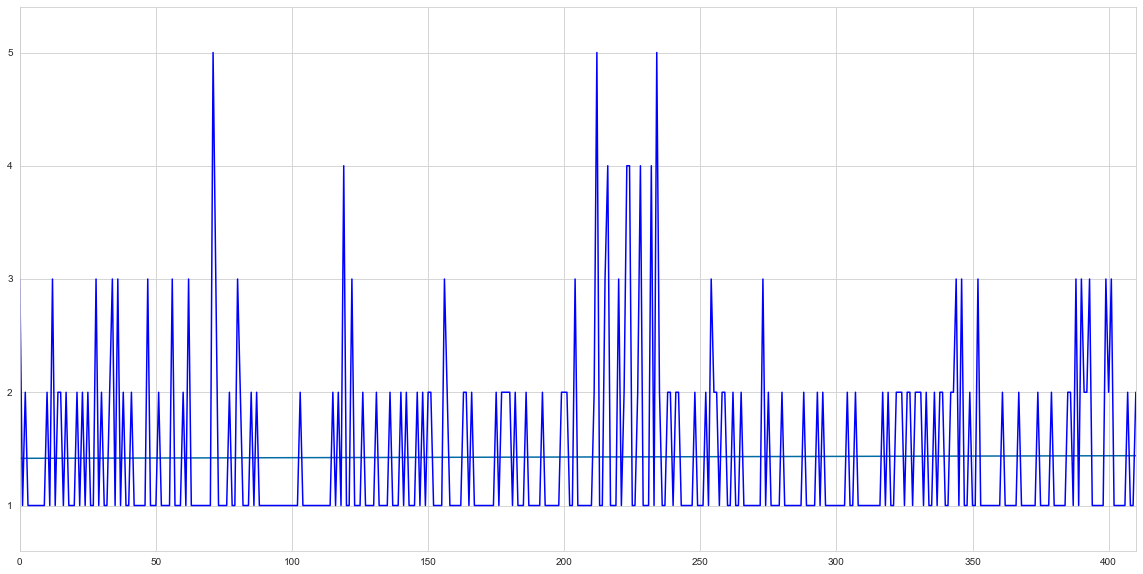

In [34]:
from statsmodels.graphics.regressionplots import abline_plot
fig = abline_plot(model_results=results)
ax = fig.axes[0]
ax.plot(X[:,1], y, 'b')
ax.margins(.1)

#### Linear regression with mltiple variables ?

In [119]:
df_q = series.query("product_id == '5cebfa8d0b259700045dc8ad'") 

In [120]:
df_q=df_q.groupby(['date','product_id']).sum().reset_index() #.drop(columns=['product_id'])
del(df_q['product_id'])
#df_q.set_index('date', inplace=True)
df_q

,date,product_count
0,2022-01-02,9
1,2022-01-03,5
2,2022-01-04,1
3,2022-01-05,2
4,2022-01-06,2
...,...,...
147,2022-06-08,4
148,2022-06-09,11
149,2022-06-10,5
150,2022-06-11,2


In [121]:
df_q['date'] = pd.to_datetime(df.date, format='%Y-%m-%d')
X= pd.concat([
    df_q['date'].dt.day,
    #df_q['date'].dt.month,
    df_q['date'].dt.weekday,
    df_q['date'].dt.weekofyear
],axis=1)
X.columns=['day','weekday','weekofyear']

X=pd.get_dummies(X,columns=['weekday'])

X

,day,weekofyear,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,2,52,0,0,0,0,0,0,1
1,3,1,1,0,0,0,0,0,0
2,4,1,0,1,0,0,0,0,0
3,5,1,0,0,1,0,0,0,0
4,6,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
147,29,21,0,0,0,0,0,0,1
148,30,22,1,0,0,0,0,0,0
149,31,22,0,1,0,0,0,0,0
150,1,22,0,0,1,0,0,0,0


In [122]:
#df_q.tail()
rng = pd.date_range(datetime.date(2022,5,1), periods=120, freq='D')
forw = pd.DataFrame({ 'date': rng,'product_count':np.nan}) 

X_for= pd.concat([
    forw['date'].dt.day,
    #forw['date'].dt.month,
    forw['date'].dt.weekday,
    forw['date'].dt.weekofyear
],axis=1)
X_for.columns=['day','weekday','weekofyear']

X_for=pd.get_dummies(X_for,columns=['weekday'])

X_for 

,day,weekofyear,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,1,17,0,0,0,0,0,0,1
1,2,18,1,0,0,0,0,0,0
2,3,18,0,1,0,0,0,0,0
3,4,18,0,0,1,0,0,0,0
4,5,18,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
115,24,34,0,0,1,0,0,0,0
116,25,34,0,0,0,1,0,0,0
117,26,34,0,0,0,0,1,0,0
118,27,34,0,0,0,0,0,1,0


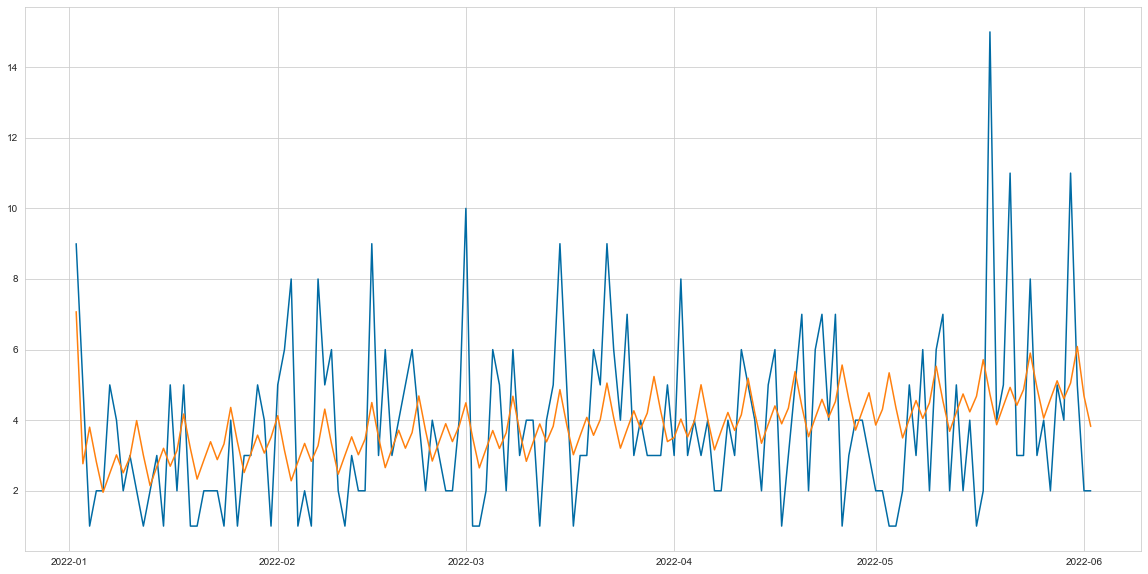

In [112]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
lr.fit(X,df_q['product_count'])

# predict on the same period
preds = lr.predict(X)

# plot what has been learned
plt.plot(df_q['date'], df_q['product_count'])
plt.plot(df_q['date'], preds)

In [113]:
coeff=lr.coef_
pd.Series(coeff,index=X.columns)

day           0.013572
weekofyear    0.091372
weekday_0     0.039954
weekday_1     1.062779
weekday_2     0.068331
weekday_3    -0.808877
weekday_4    -0.287040
weekday_5     0.223198
weekday_6    -0.298345
dtype: float64

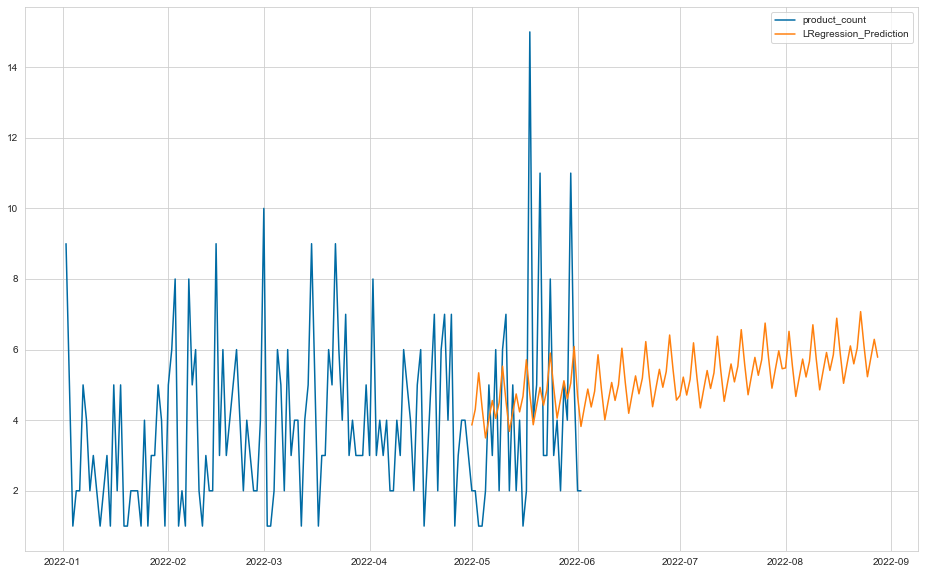

In [114]:
# predict on the future period with Regression
predict = lr.predict(X_for)

# plot what has been learned
#plt.fig(figuresize=(16,10))
fig = plt.figure(1, figsize=(16, 10))
plt.plot(df_q['date'], df_q['product_count'])
plt.plot(forw['date'], predict)
plt.legend(['product_count', 'LRegression_Prediction'])
plt.show()

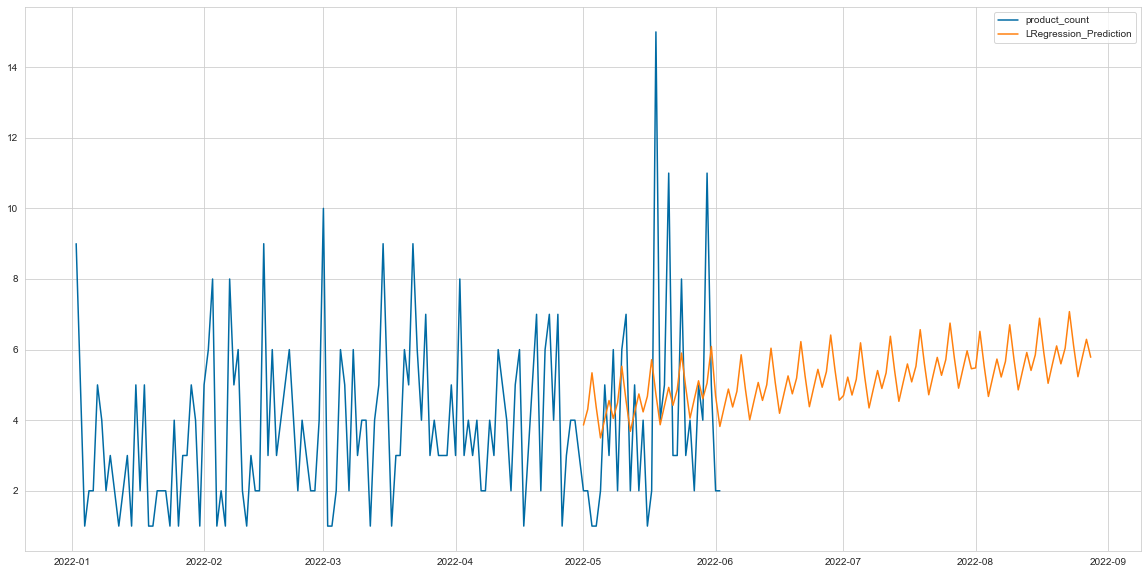

In [117]:
# plot what has been learned
plt.plot(df_q['date'], df_q['product_count'])
plt.plot(forw['date'], predict)
plt.plot(model_results=results)
ax.plot(forw['date'], y)
plt.legend(['product_count', 'LRegression_Prediction'])

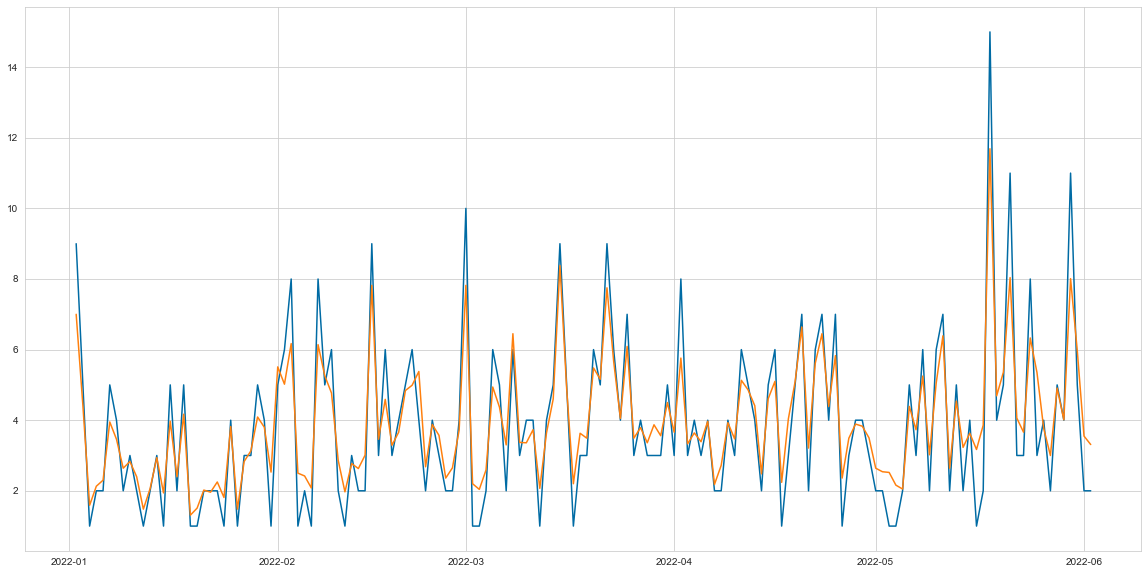

In [123]:
from sklearn.ensemble import RandomForestRegressor
 
# fit the model
rf = RandomForestRegressor()
rf.fit(X, df_q['product_count'])
 
# predict on the same period
preds = rf.predict(X)
 
# plot what has been learned
plt.plot(df_q['date'], df_q['product_count'])
plt.plot(df_q['date'], preds)

In [124]:
MSE=mean_squared_error(y_true=df_q['product_count'],
                   y_pred=preds)
MAE=mean_absolute_error(y_true=df_q['product_count'],
                   y_pred=preds)
MSLE=mean_squared_log_error(y_true=df_q['product_count'],
                   y_pred=preds)
print('MSE: %.3f' % MSE)
print('MAE: %.3f' % MAE)
print('MSLE: %.3f' %MSLE)

MSE: 0.922
MAE: 0.744
MSLE: 0.049


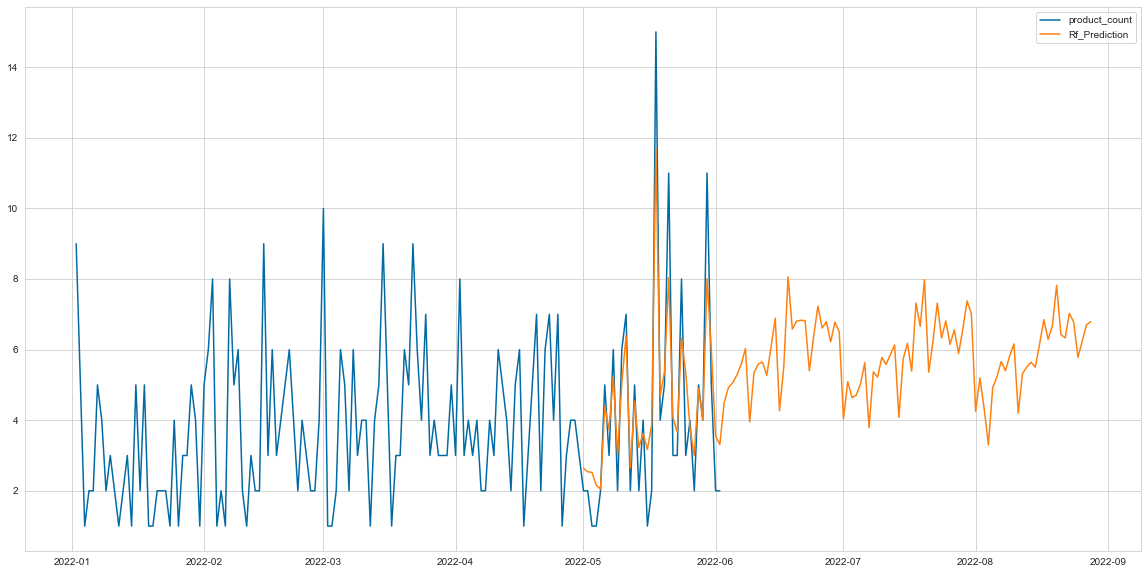

In [125]:
# predict on the future period
predict = rf.predict(X_for)
 
# plot what has been learned
plt.plot(df_q['date'], df_q['product_count'])
plt.plot(forw['date'], predict)
plt.legend(['product_count', 'Rf_Prediction'])

Text(0.5, 0, 'Relative Importance')

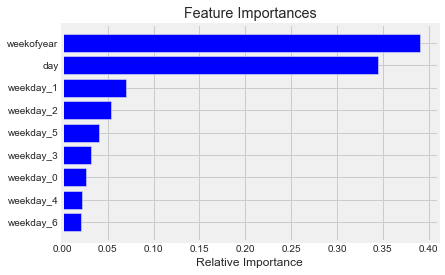

In [126]:
importances = rf.feature_importances_
indices = np.argsort(importances)
# style du graphique 
liste_variables = list(pd.DataFrame(X).columns)
plt.style.use('fivethirtyeight')
%matplotlib inline
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [liste_variables[i] for i in indices])
plt.xlabel('Relative Importance')